In [1]:
from rdkit.Chem import AllChem as Chem
import psycopg2 as pg
import pickle
import rdkit.Chem.Draw as Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
c = pg.connect("dbname=drugbank user=script password=pnl") # create a connection

In [3]:
cursor = c.cursor() # grab a connection cursor

In [4]:
cursor.execute("select mol_numatoms('CCO'::mol)") # test the rdkit cartridge functionality
cursor.fetchall()

[(9,)]

In [5]:
c.rollback() # run in case of transaction block

In [6]:
suppl = Chem.SDMolSupplier("../cdd2019/data/drugbank.sdf")
drugbank = [m for m in suppl if m]

RDKit ERROR: [13:07:04] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [13:07:04] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [13:07:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [13:07:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [13:07:04] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [13:07:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [13:07:04] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [13:07:04] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [13:07:04] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [13:07:04] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [13:07:04] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [13:07:04] Can't kek

RDKit ERROR: [13:07:04] ERROR: Explicit valence for atom # 53 N, 4, is greater than permitted
RDKit ERROR: [13:07:05] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 12
RDKit ERROR: 
RDKit ERROR: [13:07:05] ERROR: Could not sanitize molecule ending on line 480504
RDKit ERROR: [13:07:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 12
RDKit ERROR: 
RDKit ERROR: [13:07:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [13:07:05] ERROR: Could not sanitize molecule ending on line 499305
RDKit ERROR: [13:07:05] ERROR: Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [13:07:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:07:05] ERROR: Could not sanitize molecule ending on line 503342
RDKit ERROR: [13:07:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:07:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
R

In [7]:
possible_columns = set()
for m in drugbank:
    possible_columns.update(m.GetPropsAsDict())
possible_columns

{'ALOGPS_LOGP',
 'ALOGPS_LOGS',
 'ALOGPS_SOLUBILITY',
 'DATABASE_ID',
 'DATABASE_NAME',
 'DRUGBANK_ID',
 'DRUG_GROUPS',
 'EXACT_MASS',
 'FORMULA',
 'GENERIC_NAME',
 'INCHI_IDENTIFIER',
 'INCHI_KEY',
 'INTERNATIONAL_BRANDS',
 'JCHEM_ACCEPTOR_COUNT',
 'JCHEM_ATOM_COUNT',
 'JCHEM_AVERAGE_POLARIZABILITY',
 'JCHEM_BIOAVAILABILITY',
 'JCHEM_DONOR_COUNT',
 'JCHEM_FORMAL_CHARGE',
 'JCHEM_GHOSE_FILTER',
 'JCHEM_IUPAC',
 'JCHEM_LOGP',
 'JCHEM_MDDR_LIKE_RULE',
 'JCHEM_NUMBER_OF_RINGS',
 'JCHEM_PHYSIOLOGICAL_CHARGE',
 'JCHEM_PKA',
 'JCHEM_PKA_STRONGEST_ACIDIC',
 'JCHEM_PKA_STRONGEST_BASIC',
 'JCHEM_POLAR_SURFACE_AREA',
 'JCHEM_REFRACTIVITY',
 'JCHEM_ROTATABLE_BOND_COUNT',
 'JCHEM_RULE_OF_FIVE',
 'JCHEM_TRADITIONAL_IUPAC',
 'JCHEM_VEBER_RULE',
 'MOLECULAR_WEIGHT',
 'PRODUCTS',
 'SALTS',
 'SECONDARY_ACCESSION_NUMBERS',
 'SMILES',
 'SYNONYMS'}

let's select actual columns for the molecule instance:

In [8]:
molecule_columns = (
'ALOGPS_LOGP',
 'ALOGPS_LOGS',
 'ALOGPS_SOLUBILITY',
 'DATABASE_ID',
 'DATABASE_NAME',
 'DRUGBANK_ID',
 'EXACT_MASS',
 'FORMULA',
 'GENERIC_NAME',
 'INCHI_IDENTIFIER',
 'INCHI_KEY',
 'JCHEM_ACCEPTOR_COUNT',
 'JCHEM_ATOM_COUNT',
 'JCHEM_AVERAGE_POLARIZABILITY',
 'JCHEM_BIOAVAILABILITY',
 'JCHEM_DONOR_COUNT',
 'JCHEM_FORMAL_CHARGE',
 'JCHEM_GHOSE_FILTER',
 'JCHEM_IUPAC',
 'JCHEM_LOGP',
 'JCHEM_MDDR_LIKE_RULE',
 'JCHEM_NUMBER_OF_RINGS',
 'JCHEM_PHYSIOLOGICAL_CHARGE',
 'JCHEM_PKA',
 'JCHEM_PKA_STRONGEST_ACIDIC',
 'JCHEM_PKA_STRONGEST_BASIC',
 'JCHEM_POLAR_SURFACE_AREA',
 'JCHEM_REFRACTIVITY',
 'JCHEM_ROTATABLE_BOND_COUNT',
 'JCHEM_RULE_OF_FIVE',
 'JCHEM_TRADITIONAL_IUPAC',
 'JCHEM_VEBER_RULE',
 'MOLECULAR_WEIGHT',
 'SMILES'
)

Let's fill the database with drugbank molecules:

In [9]:
def molecule2insertstring(mol, columns):
    values = []
    for c in columns:
        try:
            value = "'{}'".format(mol.GetProp(c).replace("'", "''"))
        except KeyError:
            value = 'null'
        values.append(value)
    return "({})".format(", ".join(values))

In [10]:
molecule2insertstring(drugbank[54], molecule_columns)

"('6.38', '-4.58', '7.58e-03 g/l', 'DB00162', 'drugbank', 'DB00162', '286.229665582', 'C20H30O', 'Vitamin A', 'InChI=1S/C20H30O/c1-16(8-6-9-17(2)13-15-21)11-12-19-18(3)10-7-14-20(19,4)5/h6,8-9,11-13,21H,7,10,14-15H2,1-5H3/b9-6+,12-11+,16-8+,17-13+', 'FPIPGXGPPPQFEQ-OVSJKPMPSA-N', '1', null, '36.427750862861046', '1', '1', '0', '1', '(2E,4E,6E,8E)-3,7-dimethyl-9-(2,6,6-trimethylcyclohex-1-en-1-yl)nona-2,4,6,8-tetraen-1-ol', '4.694093173000001', '0', '1', '0', null, '16.435769749539965', '-2.1707943115512176', '20.23', '97.92339999999999', '5', '1', 'α-sol', '1', '286.4516', 'C\\C(=C/CO)\\C=C\\C=C(/C)\\C=C\\C1=C(C)CCCC1(C)C')"

In [11]:
query = "insert into drugbank.molecule ({}) values {}".format(
    ", ".join(molecule_columns),
    ", ".join((molecule2insertstring(mol, molecule_columns) for mol in drugbank)))

In [12]:
c.rollback()
cursor.execute(query)

In [13]:
c.commit()

In [14]:
cursor.execute("select count(*) from drugbank.molecule")
cursor.fetchall()

[(7113,)]

In [15]:
cursor.execute("select * from drugbank.molecule limit 10")
cursor.fetchall()

[(1,
  None,
  None,
  -0.76,
  -4.67,
  '4.64e-02 g/l',
  'DB00006',
  'drugbank',
  'DB00006',
  2178.985813062,
  'C98H138N24O33',
  'Bivalirudin',
  'InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122-39-15-23-70(122)92(149)114-60(30-34-79(134)135)85(142)111-59(29-33-78(132)133)86(143)116-64(43-55-24-26-56(123)27-25-55)89(146)118-67(97(154)155)40-51(2)3)119-87(144)61(31-35-80(136)137)112-84(141)58(28-32-77(130)131)113-88(145)63(42-54-18-10-7-11-19-54)117-90(147)66(45-81(138)139)110-76(129)50-107-83(140)65(44-71(100)124)109-75(128)49-106-73(126)47-104-72(125)46-105-74(127)48-108-91(148)68-21-13-38-121(68)95(152)62(20-12-36-103-98(101)102)115-93(150)69-22-14-37-120(69)94(151)57(99)41-53-16-8-6-9-17-53/h6-11,16-19,24-27,51-52,57-70,82,123H,5,12-15,20-23,28-50,99H2,1-4H3,(H2,100,124)(H,104,125)(H,105,127)(H,106,126)(H,107,140)(H,108,148)(H,109,128)(H,110,129)(H,111,142)(H,112,141)(H,113,145)(H,114,149)(H,115,150)(H,116,143)(H,117,147)(H,118,146)(H,119,144)(H,130,131)(H,132,133)(H,134,135)(

In [16]:
cursor.execute("select * from drugbank.molecule order by EXACT_MASS limit 10")
cursor.fetchall()

[(6875,
  None,
  None,
  None,
  None,
  None,
  'DB09155',
  'drugbank',
  'DB09155',
  4.00260325,
  'He',
  'Helium',
  'InChI=1S/He',
  'SWQJXJOGLNCZEY-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '0',
  '0',
  'helium',
  0.0,
  '0',
  0,
  '0',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'helium',
  '1',
  4.0026,
  '[He]'),
 (1189,
  None,
  None,
  None,
  None,
  None,
  'DB01356',
  'drugbank',
  'DB01356',
  7.016004049,
  'Li',
  'Lithium',
  'InChI=1S/Li/q+1',
  'HBBGRARXTFLTSG-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '1',
  '0',
  'lithium(1+) ion',
  0.0,
  '0',
  0,
  '1',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'lithium(1+) ion',
  '1',
  6.941,
  '[Li+]'),
 (6981,
  None,
  None,
  -1.31,
  1.08,
  '0.00e+00 g/l',
  'DB09278',
  'drugbank',
  'DB09278',
  12.0,
  'C',
  'Activated charcoal',
  'InChI=1S/C',
  'OKTJSMMVPCPJKN-UHFFFAOYSA-N',
  0,
  1,
  1.50802392,
  '1',
  0,
  '0',
  '0',
  'carbon',
  0.0,
  '0',
  0,
  '0',
  None,

## Filling the chemical data columns - molecule instance, binary fingerprints

In [19]:
c.rollback()
cursor.execute("update drugbank.molecule set rdmol = mol_from_smiles(SMILES::CSTRING)")

In [20]:
cursor.execute("select * from drugbank.molecule order by EXACT_MASS limit 10")
cursor.fetchall()

[(6875,
  '[He]',
  None,
  None,
  None,
  None,
  'DB09155',
  'drugbank',
  'DB09155',
  4.00260325,
  'He',
  'Helium',
  'InChI=1S/He',
  'SWQJXJOGLNCZEY-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '0',
  '0',
  'helium',
  0.0,
  '0',
  0,
  '0',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'helium',
  '1',
  4.0026,
  '[He]'),
 (1189,
  '[Li+]',
  None,
  None,
  None,
  None,
  'DB01356',
  'drugbank',
  'DB01356',
  7.016004049,
  'Li',
  'Lithium',
  'InChI=1S/Li/q+1',
  'HBBGRARXTFLTSG-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '1',
  '0',
  'lithium(1+) ion',
  0.0,
  '0',
  0,
  '1',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'lithium(1+) ion',
  '1',
  6.941,
  '[Li+]'),
 (6981,
  '[C]',
  None,
  -1.31,
  1.08,
  '0.00e+00 g/l',
  'DB09278',
  'drugbank',
  'DB09278',
  12.0,
  'C',
  'Activated charcoal',
  'InChI=1S/C',
  'OKTJSMMVPCPJKN-UHFFFAOYSA-N',
  0,
  1,
  1.50802392,
  '1',
  0,
  '0',
  '0',
  'carbon',
  0.0,
  '0',
  0,
  '0',
 

In [21]:
c.commit()

In [22]:
c.rollback()
cursor.execute("update drugbank.molecule set morganfp = morganbv_fp(rdmol)")

In [23]:
c.commit()

In [24]:
cursor.execute("select * from drugbank.molecule order by EXACT_MASS limit 10")
cursor.fetchall()

[(6875,
  '[He]',
  '\\x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000200',
  None,
  None,
  None,
  'DB09155',
  'drugbank',
  'DB09155',
  4.00260325,
  'He',
  'Helium',
  'InChI=1S/He',
  'SWQJXJOGLNCZEY-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '0',
  '0',
  'helium',
  0.0,
  '0',
  0,
  '0',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'helium',
  '1',
  4.0026,
  '[He]'),
 (1189,
  '[Li+]',
  '\\x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000',
  None,
  None,
  None,
  'DB01356',
  'drugbank',
  'DB01356',
  7.016004049,
  'Li',
  'Lithium',
  'InChI=1S/Li/q+1',
  'HBBGRARXTFLTSG-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '1',
  '0',
  'lithium(1+) ion',
  0.0,
  '0',
  0,
  '1',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'lithium(1+) ion',
  '1',
  6.941,
  '[Li+]'),
 (6981,
  '[C]',
  

## Now, for some sim search

In [26]:
cursor.execute("select * from drugbank.molecule where morganfp%morganbv_fp('O=C(C)Oc1ccccc1C(=O)O'::mol)")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O'),
 (1215,
  'O=C(Oc1ccccc1C(=O)O)c1ccccc1O',
  '\\x00008000000000008500010000000001000402000080800802004000000000000000000080004000000002001000002024200000800084008001000000000000',
  3.44,
  -3.02,
  '2.46e-01 g/l',
  'DB01399',
  'drugbank',
  'DB01399',
  258.05282343,
  'C14H10O5',
  'Salsalate',
  'InChI=1S/C14H10O5/c

## Substructure search

In [28]:
c.rollback()
cursor.execute("select * from drugbank.molecule where rdmol@>'O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O'),
 (1215,
  'O=C(Oc1ccccc1C(=O)O)c1ccccc1O',
  '\\x00008000000000008500010000000001000402000080800802004000000000000000000080004000000002001000002024200000800084008001000000000000',
  3.44,
  -3.02,
  '2.46e-01 g/l',
  'DB01399',
  'drugbank',
  'DB01399',
  258.05282343,
  'C14H10O5',
  'Salsalate',
  'InChI=1S/C14H10O5/c

In [30]:
c.rollback()
cursor.execute("select * from drugbank.molecule where rdmol@>'CCO'::mol limit 10")
cursor.fetchall()

[(2,
  'CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)NNC(N)=O',
  '\\x12000800a20000208d8043440010e5001195a90000818210020661448902844000000048c220c014282382821c148634400142c2800004400927540205014099',
  0.3,
  -4.65,
  '2.83e-02 g/l',
  'DB00014',
  'drugbank',
  'DB00014',
  1268.641439486,
  'C59H84N18O14',
  'Goserelin',
  'InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-39(12-8-20-64-57(60)61)56(89)77-21-9-13-46(77)55(88)75-76-58(62)90)69-54(87)45(29-91-59(3,4)5)74-50(83)41(23-32-14-16-35(79)17-15-32)70-53(86)44(28-78)73-51(84)42(24-33-26-65-37-11-7-6-10-36(33)37)71-52(85)43(25-34-27-63-30-66-34)72-48(81)38-18-19-47(80)67-38/h6-7,10-11,14-17,26-27,30-31,38-46,65,78-79H,8-9,12-13,18-25,28-29H2,1-5H3,(H,63,66)(H,67,80)(H,68,82)(H,69,87)(H,70,86)(H,71,85)(H,72,81)(H,73,84)(H,74,83)(H,75,88)(H4,60,61,64)(H3,62,76,90)/t38-,39-,40-,41-,42-,

In [31]:
c.rollback()
cursor.execute("select * from drugbank.molecule where rdmol<@'O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(7074,
  'Cc1ccccc1',
  '\\x00000080020000000100000000000000000000000080000400004000000000000000008000000000000002001000000021000000000000000000000000000000',
  2.56,
  -2.26,
  '5.08e-01 g/l',
  'DB11558',
  'drugbank',
  'DB11558',
  92.062600256,
  'C7H8',
  'Toluene',
  'InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3',
  'YXFVVABEGXRONW-UHFFFAOYSA-N',
  0,
  None,
  10.9742444891749,
  '1',
  0,
  '0',
  '0',
  'toluene',
  2.48666720533333,
  '0',
  1,
  '0',
  None,
  None,
  None,
  0.0,
  31.0992,
  0,
  1,
  'toluene',
  '1',
  92.1384,
  'CC1=CC=CC=C1'),
 (780,
  'CCO',
  '\\x000000000200000000000100000000000000000000000000000000400000000000000000c0000000000000000000000004000000000000000000000000000000',
  -0.4,
  1.1,
  '5.79e+02 g/l',
  'DB00898',
  'drugbank',
  'DB00898',
  46.041864814,
  'C2H6O',
  'Ethanol',
  'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3',
  'LFQSCWFLJHTTHZ-UHFFFAOYSA-N',
  1,
  None,
  5.30376267743943,
  '1',
  1,
  '0',
  '0',
  'ethanol',
  -0.161769114,
  '0',
 

In [32]:
c.rollback()
cursor.execute("select * from drugbank.molecule where rdmol@='O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O')]

## Transferring instances

In [34]:
c.rollback()
cursor.execute("select id, mol_to_pkl(rdmol) from drugbank.molecule where rdmol<@'O=C(C)Oc1ccccc1C(=O)O'::mol")
results = cursor.fetchall()
results

[(7074, <memory at 0x7f1e52d08f48>),
 (780, <memory at 0x7f1e52c617c8>),
 (817, <memory at 0x7f1e52c61888>),
 (826, <memory at 0x7f1e52c61948>),
 (1691, <memory at 0x7f1e52c61a08>),
 (2879, <memory at 0x7f1e52c61ac8>),
 (4668, <memory at 0x7f1e52c61b88>),
 (3359, <memory at 0x7f1e52c61c48>),
 (3406, <memory at 0x7f1e52c61d08>),
 (6865, <memory at 0x7f1e52c61dc8>)]

In [44]:
results_bytes = [(idx, result.tobytes()) for idx, result in results]
results_bytes

[(7074,
  b'\xef\xbe\xad\xde\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x07\x00\x00\x00\x80\x01\x06\x00`\x00\x00\x00\x01\x03\x06@(\x00\x00\x00\x03\x04\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x0b\x00\x01\x00\x01\x02h\x0c\x02\x03h\x0c\x03\x04h\x0c\x04\x05h\x0c\x05\x06h\x0c\x06\x01h\x0c\x14\x01\x06\x01\x06\x05\x04\x03\x02\x17\x00\x00\x00\x00\x16'),
 (780,
  b'\xef\xbe\xad\xde\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x02\x00\x00\x00\x80\x01\x06\x00`\x00\x00\x00\x01\x03\x06\x00`\x00\x00\x00\x02\x02\x08\x00`\x00\x00\x00\x01\x01\x0b\x00\x01\x00\x01\x02\x00\x14\x00\x17\x00\x00\x00\x00\x16'),
 (817,
  b'\xef\xbe\xad\xde\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x00\x00\x00\n\x00\x00\x00\x80\x01\x08\x00h\x00\x00\x00\x03\x01\x01\x06\x00(\x00\x00\x00\x03\x04\x08\x00(\x00\x00\x00\x03\x02\x06@(\x00\

In [45]:
results_mols = [(idx, Chem.Mol(result.tobytes())) for idx, result in results]
results_mols

[(7074, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03998>),
 (780, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03a08>),
 (817, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03810>),
 (826, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03a78>),
 (1691, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03848>),
 (2879, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03a40>),
 (4668, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03880>),
 (3359, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03b58>),
 (3406, <rdkit.Chem.rdchem.Mol at 0x7f1e50a038b8>),
 (6865, <rdkit.Chem.rdchem.Mol at 0x7f1e50a03bc8>)]

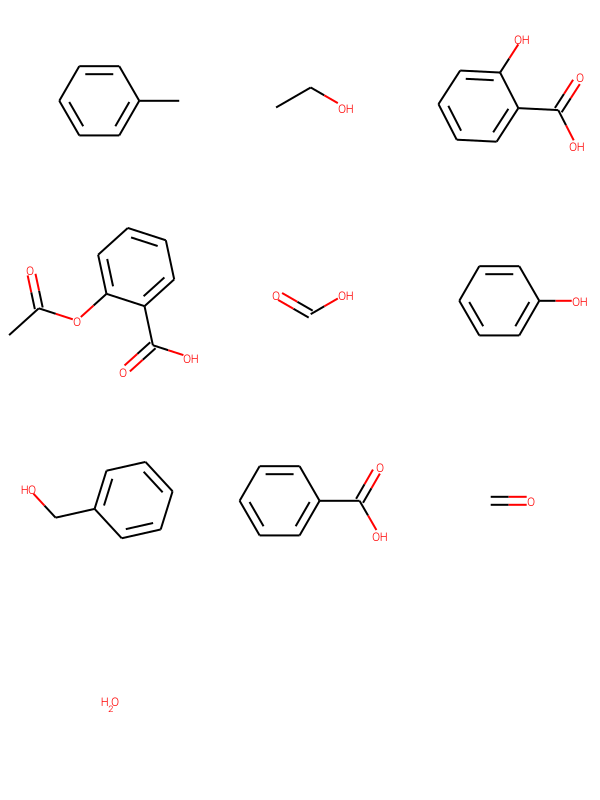

In [41]:
Draw.MolsToGridImage([m for idx, m in results_mols])

In [47]:
aspirin = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")

In [48]:
aspirin.ToBinary()

b'\xef\xbe\xad\xde\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\r\x00\x00\x00\r\x00\x00\x00\x80\x01\x08\x00(\x00\x00\x00\x03\x02\x06\x00(\x00\x00\x00\x03\x04\x06\x00`\x00\x00\x00\x01\x03\x08\x00(\x00\x00\x00\x03\x02\x06@(\x00\x00\x00\x03\x04\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@(\x00\x00\x00\x03\x04\x06\x00(\x00\x00\x00\x03\x04\x08\x00(\x00\x00\x00\x03\x02\x08\x00h\x00\x00\x00\x03\x01\x01\x0b\x00\x01(\x02\x01\x02\x00\x01\x03 \x03\x04 \x04\x05h\x0c\x05\x06h\x0c\x06\x07h\x0c\x07\x08h\x0c\x08\th\x0c\t\n \n\x0b(\x02\n\x0c \t\x04h\x0c\x14\x01\x06\x04\t\x08\x07\x06\x05\x17\x00\x00\x00\x00\x16'

In [54]:
c.rollback()
cursor.execute("select id, mol_to_pkl(rdmol) from drugbank.molecule where rdmol<@mol_from_pkl({})".format(
    pg.Binary(aspirin.ToBinary())))
results = cursor.fetchall()
results

[(7074, <memory at 0x7f1e50a10948>),
 (780, <memory at 0x7f1e50a10a08>),
 (817, <memory at 0x7f1e50a10ac8>),
 (826, <memory at 0x7f1e50a10b88>),
 (1691, <memory at 0x7f1e50a10c48>),
 (2879, <memory at 0x7f1e50a10d08>),
 (4668, <memory at 0x7f1e50a10dc8>),
 (3359, <memory at 0x7f1e50a10e88>),
 (3406, <memory at 0x7f1e50a10f48>),
 (6865, <memory at 0x7f1e50a18048>)]

## Other tables

In [58]:
for m in drugbank[:100]:
    try:
        print(m.GetProp('SYNONYMS'))
    except KeyError:
        pass

1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin; 1-deamino-8-D-arginine vasopressin; 1-Desamino-8-D-arginine vasopressin; DDAVP; Desmopresina; Desmopressine; Desmopressinum
Cetrorelixum
Ciclosporin; Ciclosporina; Ciclosporine; Ciclosporinum; CsA; CyA; Cyclosporin; Cyclosporin A
2-(L-phenylalanine)-8-L-lysinevasopressin; Felipresina; Felypressin; Felypressine; Felypressinum; PLV-2
Octreotida; Octreotidum; Octrotide
3-hydroxy-2-methyl-5-((phosphonooxy)methyl)-4-pyridinecarboxaldehyde; 3-hydroxy-5-(hydroxymethyl)-2-methylisonicotinaldehyde 5-phosphate; Codecarboxylase; PLP; Pyridoxal 5-monophosphoric acid ester; Pyridoxal 5-phosphate; Pyridoxal 5'-phosphate; Pyridoxal P; Pyridoxal phosphate anhydrous; Pyridoxal-5P; Pyridoxal-P
Cyanocob(III)alamin; Vitamin B12; Vitamin B12 complex
5,6,7,8-tetrahydrofolate; 5,6,7,8-tetrahydrofolic acid; tetrahydrofolate
(S)-4-(2-Amino-2-carboxyethyl)imidazole; (S)-a-Amino-1H-imidazole-4-propanoic acid; (S)-alpha-Amino-1H-imidazole-4-propionic acid; (S

In [59]:
cursor.execute("select id, DRUGBANK_ID from drugbank.molecule limit 5")
cursor.fetchall()

[(2, 'DB00014'),
 (3, 'DB00035'),
 (4, 'DB00050'),
 (5, 'DB00091'),
 (16, 'DB00122')]

In [60]:
cursor.execute("select id, DRUGBANK_ID from drugbank.molecule")
drugbank2databaseid = {drugbank: idx for idx, drugbank in cursor.fetchall()}
drugbank2databaseid

{'DB00014': 2,
 'DB00035': 3,
 'DB00050': 4,
 'DB00091': 5,
 'DB00122': 16,
 'DB00093': 6,
 'DB00104': 7,
 'DB00114': 8,
 'DB00115': 9,
 'DB00116': 10,
 'DB09316': 7010,
 'DB00117': 11,
 'DB00118': 12,
 'DB00119': 13,
 'DB00120': 14,
 'DB00121': 15,
 'DB00123': 17,
 'DB00125': 18,
 'DB00126': 19,
 'DB00127': 20,
 'DB00128': 21,
 'DB00129': 22,
 'DB00130': 23,
 'DB00131': 24,
 'DB00132': 25,
 'DB00133': 26,
 'DB00134': 27,
 'DB00135': 28,
 'DB00136': 29,
 'DB00137': 30,
 'DB00138': 31,
 'DB00139': 32,
 'DB01574': 1364,
 'DB00140': 33,
 'DB00143': 36,
 'DB00144': 37,
 'DB00145': 38,
 'DB00146': 39,
 'DB00147': 40,
 'DB00148': 41,
 'DB00149': 42,
 'DB00150': 43,
 'DB00151': 44,
 'DB00152': 45,
 'DB00161': 54,
 'DB00172': 64,
 'DB00153': 46,
 'DB00154': 47,
 'DB01576': 1365,
 'DB00155': 48,
 'DB00156': 49,
 'DB07650': 5511,
 'DB00157': 50,
 'DB00158': 51,
 'DB00159': 52,
 'DB00160': 53,
 'DB00162': 55,
 'DB00163': 56,
 'DB00165': 57,
 'DB00166': 58,
 'DB00167': 59,
 'DB00168': 60,
 'DB0016

In [73]:
def molecule2synonyms(m):
    try:
        synonyms = [syn.strip().replace("'", "''") for syn in m.GetProp('SYNONYMS').split(";")]
    except KeyError:
        synonyms = []
    return synonyms

molecule2synonyms(drugbank[666])

['Propantelina bromuro',
 'Propantelina, bromuro de',
 'Propanthelin bromid',
 'Propanthéline, bromure de',
 'Propanthelini Bromidum']

In [69]:
def molecule2synonym_insertstring(m, drugbank2database):
    databaseid = drugbank2database[m.GetProp('DRUGBANK_ID')]
    return ",".join(["({}, '{}')".format(databaseid, synonym) for synonym in molecule2synonyms(m)])

In [70]:
molecule2synonym_insertstring(drugbank[666], drugbank2databaseid)

"(667, 'Propantelina bromuro'),(667, 'Propantelina, bromuro de'),(667, 'Propanthelin bromid'),(667, 'Propanthéline, bromure de'),(667, 'Propanthelini Bromidum')"

In [79]:
query = "insert into drugbank.synonym (molid, name) values {}".format(','.join(
    [molecule2synonym_insertstring(m, drugbank2databaseid) for m in drugbank if molecule2synonym_insertstring(m, drugbank2databaseid)]))
c.rollback()
cursor.execute(query)

In [80]:
c.commit()

In [81]:
query = "select * from drugbank.synonym limit 10"
cursor.execute(query)
cursor.fetchall()

[(1, 3, '1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin'),
 (2, 3, '1-deamino-8-D-arginine vasopressin'),
 (3, 3, '1-Desamino-8-D-arginine vasopressin'),
 (4, 3, 'DDAVP'),
 (5, 3, 'Desmopresina'),
 (6, 3, 'Desmopressine'),
 (7, 3, 'Desmopressinum'),
 (8, 4, 'Cetrorelixum'),
 (9, 5, 'Ciclosporin'),
 (10, 5, 'Ciclosporina')]

In [83]:
query = "select name, rdmol from drugbank.synonym s join drugbank.molecule m on s.molid = m.id limit 10"
cursor.execute(query)
cursor.fetchall()

[('1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('1-deamino-8-D-arginine vasopressin',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('1-Desamino-8-D-arginine vasopressin',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('DDAVP',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('Desmopresina',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C

In [88]:
c.rollback()
query = "select name, rdmol from drugbank.synonym s join drugbank.molecule m on s.molid = m.id where name like '%acid%' limit 10"
cursor.execute(query)
cursor.fetchall()

[('1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('Pyridoxal 5-monophosphoric acid ester', 'Cc1ncc(COP(=O)(O)O)c(C=O)c1O'),
 ('5,6,7,8-tetrahydrofolic acid',
  'Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1)N2'),
 ('(S)-a-Amino-1H-imidazole-4-propanoic acid', 'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('(S)-alpha-Amino-1H-imidazole-4-propionic acid',
  'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('(S)-α-amino-1H-Imidazole-4-propanoic acid', 'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('2-ketopropionic acid', 'CC(=O)C(=O)O'),
 ('2-Oxopropanoic acid', 'CC(=O)C(=O)O'),
 ('a-Ketopropionic acid', 'CC(=O)C(=O)O'),
 ('Acetylformic acid', 'CC(=O)C(=O)O')]